In [3]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy.cluster.hierarchy import linkage, cut_tree, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

In [4]:
# SETTINGS FOR PLOTTING FIGURES
PLOTS_WANTED = True
dpi_general = 500

In [5]:
# bcolors
HEADER = "\033[95m"
OKBLUE = "\033[94m"
OKCYAN = "\033[96m"
OKGREEN = "\033[92m"
WARNING = "\033[93m"
FAIL = "\033[91m"
ENDC = "\033[0m"
BOLD = "\033[1m"
UNDERLINE = "\033[4m"

In [27]:
## Move out of the notebook folder to access datasets
working_dir = os.getcwd()
working_dir = working_dir.strip('notebooks')



## Load the dataset
# Transcriptomics Data - We assume a dataset structure were col are the genes, and rows are the samples
mrna_count_dir = working_dir + 'data/5xFAD_paper/expressionList.csv'  
mrna_count = pd.read_csv(mrna_count_dir, index_col=0)

# Sample info and Clinical Traits Data
sample_info_selection_dir = working_dir + 'data/5xFAD_paper/sampleInfo.csv'
sample_info_selection = pd.read_csv(sample_info_selection_dir)

# Figures Saving output dir
figures_dir = working_dir + 'results/WGCNA_figures_own/'

# Check if the directory exists, and if not, create it
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
    print(f"{BOLD}{OKBLUE}Creating directory to save results and figures...{ENDC}")



## Make a subset to save RAM
subset_dataset_size = 50
mrna_count = mrna_count.iloc[:, :subset_dataset_size] 

# RAM usage estimation in GB
RAM_estimate = (subset_dataset_size * subset_dataset_size * 8) / (1024**3)
print(f"The aproximated RAM to analyse this size of dataset is: {RAM_estimate} GB")


The aproximated RAM to analyse this size of dataset is: 1.862645149230957e-05 GB


In [38]:
### Step 1: Data Preprocessing (Normalization)
## Preprocessing: removing obvious outlier on genes and samples



print(f"{BOLD}{OKBLUE}Pre-processing...{ENDC}")

# Prepare and clean data
# Remove genes expressed under this cutoff number along samples - use clustering of samples



## Remove genes with no variation across samples (0 vectors) 
mrna_count = mrna_count.loc[:, (mrna_count != 0).any(axis=0)]

# NOTES: Maybe no onlyt genes with no variation, but small variation.




mrna_count_filtered = mrna_count

Pre-processing...


Calculating Correlation Matrix...
Plotting and Saving the Correlation Matrix...


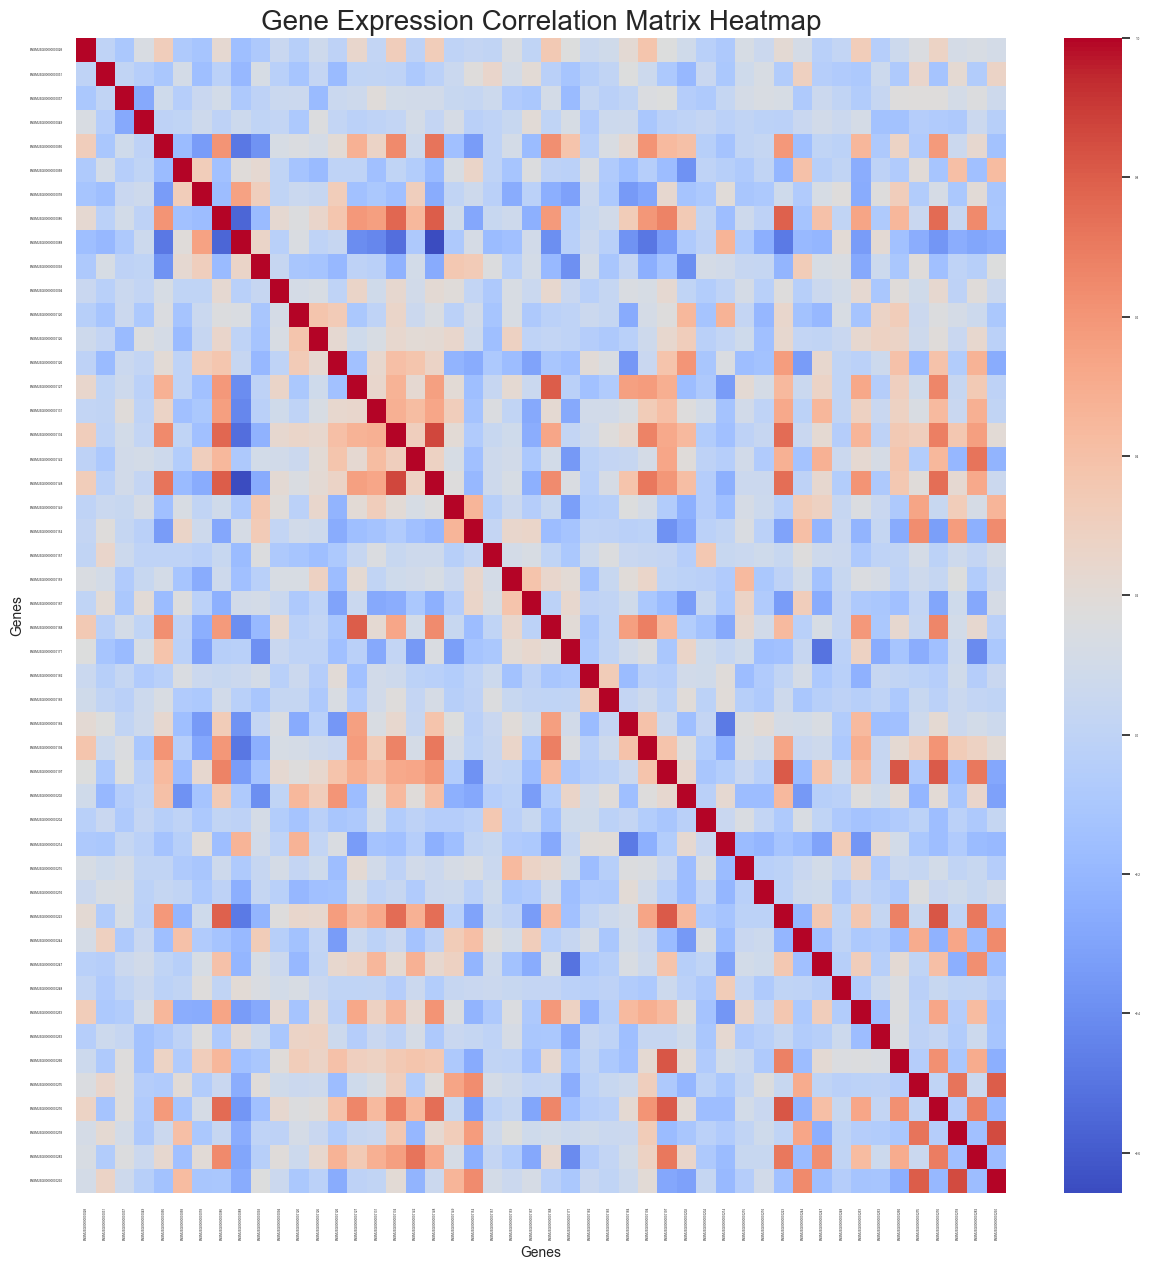

In [45]:
### Step 2: Constructing a Co-expression Similarity Matrix (Correlation Matrix)
## 

# Calculate the correlation matrix using Pearson correlation
print(f"{BOLD}{OKBLUE}Calculating Correlation Matrix...{ENDC}")
correlation_matrix = mrna_count_filtered.corr(method='pearson')

# Plotting the heatmap
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving the Correlation Matrix...{ENDC}")
    title_figure = 'Gene Expression Correlation Matrix Heatmap'

    plt.figure(figsize=(15, 15))
    sns.set(font_scale=0.2)
    sns.heatmap(correlation_matrix, cmap='coolwarm', xticklabels=True, yticklabels=True)
    plt.title(title_figure, fontsize=20)
    plt.xlabel('Genes', fontsize=10)
    plt.ylabel('Genes', fontsize=10)
    plt.savefig(figures_dir + title_figure, dpi=dpi_general)
    plt.show()

In [ ]:
### Step 5: Hierarchical clustering



METHODS = ["single", "complete", "average", "weighted", "centroid"]
method = "average"  # from the pyWGCNA

distances = pdist(mrna_count_filtered.T, metric='correlation')
dendrogram = linkage(distances, method=method)